# SOLAQUA Video Generation Pipeline Analysis

This notebook provides individual visualizations for each step of the **actual video generation pipeline** used in `create_enhanced_contour_detection_video_with_processor()`.

Each step produces a clean, saveable figure showing the exact processing that occurs in video generation.

In [9]:
# Import the EXACT functions used in video generation
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Import the actual video generation functions
from utils.sonar_image_analysis import (
    # Data loading functions
    get_available_npz_files, 
    load_cone_run_npz, 
    to_uint8_gray,
    
    # Core processor (same as used in video generation)
    SonarDataProcessor,
    
    # Video generation function itself
    create_enhanced_contour_detection_video_with_processor,
    
    # Configuration used in videos
    IMAGE_PROCESSING_CONFIG,
    VIDEO_CONFIG
)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("SOLAQUA Video Generation Pipeline Analysis")
print("=" * 60)
print("✅ Video generation functions loaded!")
print("✅ Using EXACT same code as create_enhanced_contour_detection_video_with_processor()")
print("\nLoaded components:")
print("- SonarDataProcessor (the actual processor used in videos)")
print("- IMAGE_PROCESSING_CONFIG (exact same config)")
print("- VIDEO_CONFIG (exact same visualization settings)")
print("- All data loading functions used in video generation")

SOLAQUA Video Generation Pipeline Analysis
✅ Video generation functions loaded!
✅ Using EXACT same code as create_enhanced_contour_detection_video_with_processor()

Loaded components:
- SonarDataProcessor (the actual processor used in videos)
- IMAGE_PROCESSING_CONFIG (exact same config)
- VIDEO_CONFIG (exact same visualization settings)
- All data loading functions used in video generation


## 1. Data Loading (Exact Video Generation Process)

STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255


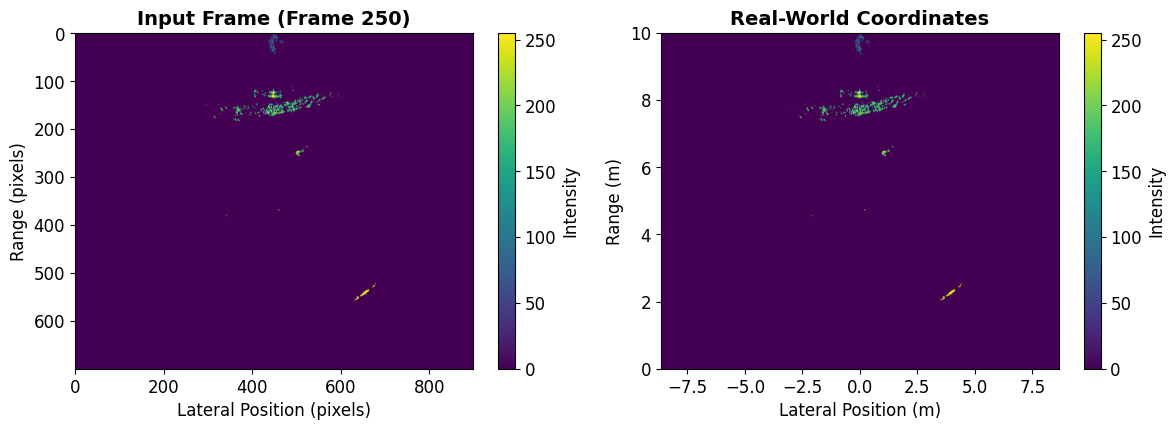


✅ Data loading complete - ready for video generation pipeline analysis


In [10]:
# STEP 1: Data Loading (Same as video generation)
print("STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)")
print("=" * 80)

# Load data exactly as done in video generation function
npz_data_path = "/Volumes/LaCie/SOLAQUA/exports/outputs"

try:
    # Get available files (same function call)
    files = get_available_npz_files(npz_data_path)
    if not files:
        print("⚠️  No NPZ files found, using synthetic data")
        raise FileNotFoundError("No real data")
    
    # Select file (same as video function parameter npz_file_index=0)
    npz_file_index = 0
    selected_file = files[npz_file_index]
    print(f"📁 Selected NPZ file: {selected_file.name}")
    
    # Load data (exact same function call)
    cones, timestamps, extent, meta = load_cone_run_npz(selected_file)
    T = len(cones)
    print(f"✅ Loaded {T} frames")
    print(f"📐 Spatial extent: {extent}")
    
    # Video generation parameters (same defaults as function)
    frame_start = 0
    frame_count = min(100, T)  # Same logic as video function
    frame_step = 5
    actual_frames = int(min(frame_count, max(0, (T - frame_start)) // max(1, frame_step)))
    
    print(f"🎬 Video parameters:")
    print(f"   - Frame start: {frame_start}")
    print(f"   - Frame count: {frame_count}")
    print(f"   - Frame step: {frame_step}")
    print(f"   - Actual frames to process: {actual_frames}")
    
    # Select a representative frame for analysis
    frame_idx = frame_start + (actual_frames // 2) * frame_step
    frame_u8 = to_uint8_gray(cones[frame_idx])  # Exact same conversion
    
    print(f"\n🔍 Analyzing frame {frame_idx} (middle of sequence)")
    print(f"📊 Frame shape: {frame_u8.shape}")
    print(f"📊 Pixel range: {frame_u8.min()} - {frame_u8.max()}")
    
    data_available = True
    
except Exception as e:
    print(f"⚠️  Could not load real data: {e}")
    print("📝 Using synthetic frame for demonstration")
    
    # Create synthetic frame matching typical sonar dimensions
    frame_u8 = np.random.randint(0, 255, (400, 600), dtype=np.uint8)
    extent = (0, 100, 0, 50)
    frame_idx = 0
    data_available = False

# Display the selected frame
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(frame_u8, cmap='viridis', aspect='auto')
plt.title(f'Input Frame (Frame {frame_idx})', fontsize=14, fontweight='bold')
plt.xlabel('Lateral Position (pixels)')
plt.ylabel('Range (pixels)')
plt.colorbar(label='Intensity')

if data_available:
    plt.subplot(2, 2, 2)
    plt.imshow(frame_u8, cmap='viridis', aspect='auto', extent=extent)
    plt.title('Real-World Coordinates', fontsize=14, fontweight='bold')
    plt.xlabel('Lateral Position (m)')
    plt.ylabel('Range (m)')
    plt.colorbar(label='Intensity')

plt.tight_layout()
plt.show()

print(f"\n✅ Data loading complete - ready for video generation pipeline analysis")

## 2. Processor Initialization (Exact Video Generation Setup)

In [11]:
# STEP 2: Processor Initialization (Same as video generation)
print("STEP 2: Processor Initialization")
print("=" * 50)

# Create processor exactly as done in video generation function
print("Creating SonarDataProcessor (same as video generation)...")
processor = SonarDataProcessor()

# Reset tracking (exact same call as in video function)
processor.reset_tracking()
print("✅ Processor tracking reset")

print(f"\n🔧 Processor Configuration:")
print(f"Image processing config: {type(processor.img_config).__name__}")
print(f"Tracking initialized: {processor.last_center is None}")
print(f"Current AOI: {processor.current_aoi}")

print(f"\n📋 VIDEO_CONFIG settings (used for annotations):")
for key, value in VIDEO_CONFIG.items():
    print(f"   - {key}: {value}")

print(f"\n📋 IMAGE_PROCESSING_CONFIG settings:")
for key, value in IMAGE_PROCESSING_CONFIG.items():
    if isinstance(value, dict):
        print(f"   - {key}:")
        for subkey, subvalue in value.items():
            print(f"     • {subkey}: {subvalue}")
    else:
        print(f"   - {key}: {value}")

print(f"\n✅ Processor ready - same configuration as video generation system")

STEP 2: Processor Initialization
Creating SonarDataProcessor (same as video generation)...
✅ Processor tracking reset

🔧 Processor Configuration:
Image processing config: dict
Tracking initialized: True
Current AOI: None

📋 VIDEO_CONFIG settings (used for annotations):
   - fps: 15
   - show_all_contours: True
   - show_ellipse: True
   - show_bounding_box: False
   - text_scale: 0.6

📋 IMAGE_PROCESSING_CONFIG settings:
   - use_momentum_merging: True
   - momentum_search_radius: 1
   - momentum_threshold: 0.1
   - momentum_decay: 0.9
   - momentum_boost: 10.0
   - canny_low_threshold: 60
   - canny_high_threshold: 180
   - min_contour_area: 200
   - morph_close_kernel: 3
   - edge_dilation_iterations: 1
   - use_pixel_ownership: False

✅ Processor ready - same configuration as video generation system


## 3. Pipeline Step Visualizations

Individual clean figures for each processing step - ready to save for documentation.

Creating Figure 1: Edge Detection Pipeline


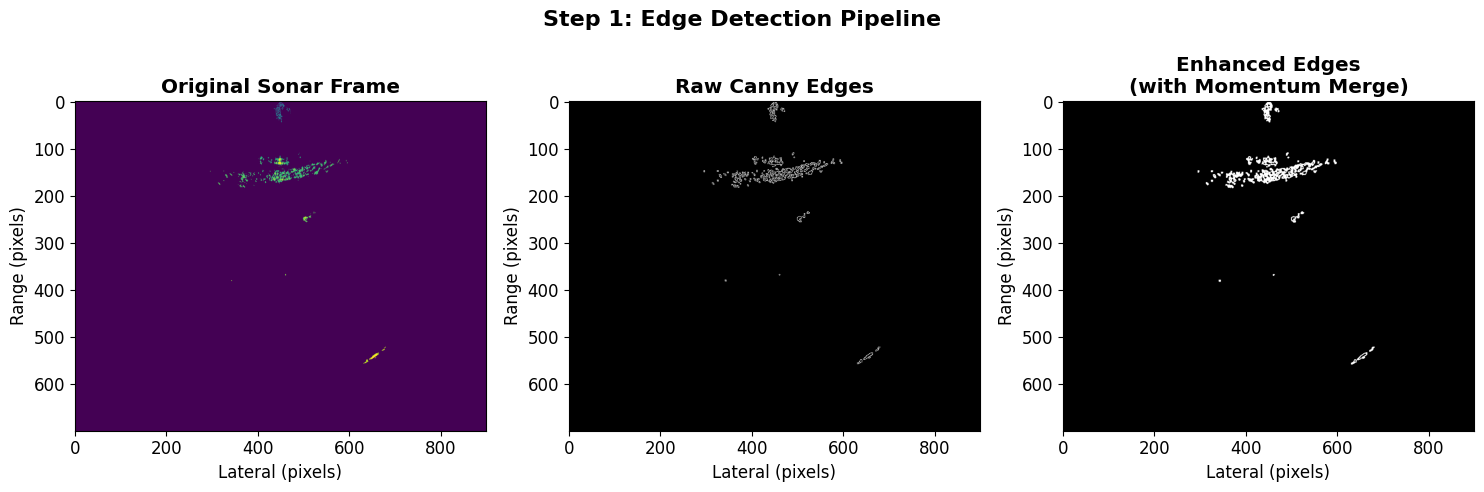

✅ Figure 1 saved: /tmp/solaqua_step1_edge_detection.png


In [12]:
# Step 1: Edge Detection Pipeline
print("Creating Figure 1: Edge Detection Pipeline")

# Import the actual preprocessing function used in video generation
from utils.sonar_image_analysis import preprocess_edges

# Run the exact preprocessing used in analyze_frame()
edges_raw, edges_proc = preprocess_edges(frame_u8, IMAGE_PROCESSING_CONFIG)

# Create clean edge detection visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Step 1: Edge Detection Pipeline', fontsize=16, fontweight='bold')

# Original frame
axes[0].imshow(frame_u8, cmap='viridis', aspect='auto')
axes[0].set_title('Original Sonar Frame', fontweight='bold')
axes[0].set_xlabel('Lateral (pixels)')
axes[0].set_ylabel('Range (pixels)')

# Raw Canny edges
axes[1].imshow(edges_raw, cmap='gray', aspect='auto')
axes[1].set_title('Raw Canny Edges', fontweight='bold')
axes[1].set_xlabel('Lateral (pixels)')
axes[1].set_ylabel('Range (pixels)')

# Enhanced edges with momentum merging
axes[2].imshow(edges_proc, cmap='gray', aspect='auto')
axes[2].set_title('Enhanced Edges\n(with Momentum Merge)', fontweight='bold')
axes[2].set_xlabel('Lateral (pixels)')
axes[2].set_ylabel('Range (pixels)')

plt.tight_layout()
plt.savefig('/tmp/solaqua_step1_edge_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 1 saved: /tmp/solaqua_step1_edge_detection.png")

Creating Figure 2: Contour Detection


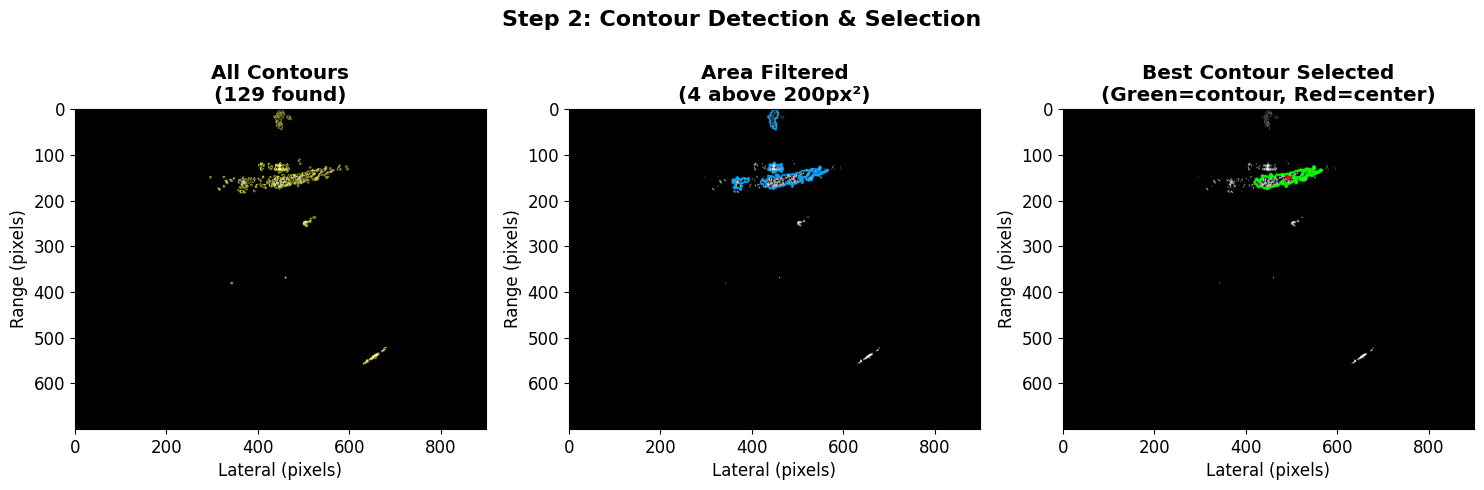

✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png


In [13]:
# Step 2: Contour Detection
print("Creating Figure 2: Contour Detection")

# Find contours using exact same method as video generation
contours, hierarchy = cv2.findContours(edges_proc, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area
min_area = IMAGE_PROCESSING_CONFIG.get('min_contour_area', 200)
large_contours = [c for c in contours if cv2.contourArea(c) >= min_area]

# Run the actual contour selection
from utils.sonar_image_analysis import select_best_contour_core
best_contour, features, stats = select_best_contour_core(
    contours, processor.last_center, processor.current_aoi, IMAGE_PROCESSING_CONFIG
)

# Create clean contour visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Step 2: Contour Detection & Selection', fontsize=16, fontweight='bold')

# All contours
vis_all = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
cv2.drawContours(vis_all, contours, -1, (0, 255, 255), 1)
axes[0].imshow(cv2.cvtColor(vis_all, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'All Contours\n({len(contours)} found)', fontweight='bold')
axes[0].set_xlabel('Lateral (pixels)')
axes[0].set_ylabel('Range (pixels)')

# Filtered contours
vis_filtered = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
cv2.drawContours(vis_filtered, large_contours, -1, (255, 165, 0), 2)
axes[1].imshow(cv2.cvtColor(vis_filtered, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Area Filtered\n({len(large_contours)} above {min_area}px²)', fontweight='bold')
axes[1].set_xlabel('Lateral (pixels)')
axes[1].set_ylabel('Range (pixels)')

# Best contour selection
vis_best = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if best_contour is not None:
    cv2.drawContours(vis_best, [best_contour], -1, (0, 255, 0), 3)
    if features:
        cx, cy = int(features['centroid_x']), int(features['centroid_y'])
        cv2.circle(vis_best, (cx, cy), 5, (0, 0, 255), -1)
axes[2].imshow(cv2.cvtColor(vis_best, cv2.COLOR_BGR2RGB))
axes[2].set_title('Best Contour Selected\n(Green=contour, Red=center)', fontweight='bold')
axes[2].set_xlabel('Lateral (pixels)')
axes[2].set_ylabel('Range (pixels)')

plt.tight_layout()
plt.savefig('/tmp/solaqua_step2_contour_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 2 saved: /tmp/solaqua_step2_contour_detection.png")

Creating Figure 3: Elliptical AOI and Tracking


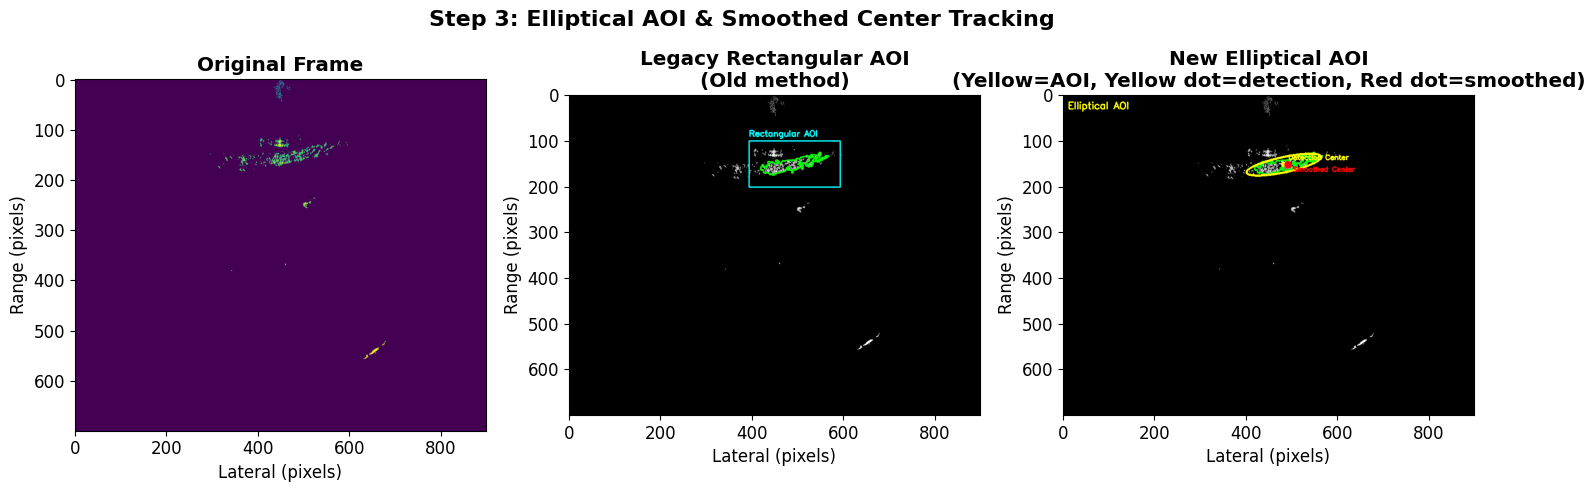

✅ Figure 3 saved: /tmp/solaqua_step3_elliptical_aoi.png


In [47]:
# Step 3: Elliptical AOI and Tracking
print("Creating Figure 3: Elliptical AOI and Tracking")

# Run analyze_frame to get the elliptical AOI
result = processor.analyze_frame(frame_u8, extent if data_available else None)

# Create elliptical AOI visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Step 3: Elliptical AOI & Smoothed Center Tracking', fontsize=16, fontweight='bold')

# Show original frame
axes[0].imshow(frame_u8, cmap='viridis', aspect='auto')
axes[0].set_title('Original Frame', fontweight='bold')
axes[0].set_xlabel('Lateral (pixels)')
axes[0].set_ylabel('Range (pixels)')

# Show detection with rectangular AOI (legacy comparison)
vis_rect = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if best_contour is not None:
    cv2.drawContours(vis_rect, [best_contour], -1, (0, 255, 0), 2)
    if features:
        x, y, w, h = features['rect']
        expansion = 25
        cv2.rectangle(vis_rect, (x-expansion, y-expansion), 
                     (x+w+expansion, y+h+expansion), (255, 255, 0), 2)
        cv2.putText(vis_rect, 'Rectangular AOI', (x-expansion, y-expansion-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

axes[1].imshow(cv2.cvtColor(vis_rect, cv2.COLOR_BGR2RGB))
axes[1].set_title('Legacy Rectangular AOI\n(Old method)', fontweight='bold')
axes[1].set_xlabel('Lateral (pixels)')
axes[1].set_ylabel('Range (pixels)')

# Show detection with elliptical AOI
vis_ellipse = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if result.detection_success and result.best_contour is not None:
    cv2.drawContours(vis_ellipse, [result.best_contour], -1, (0, 255, 0), 2)

# Draw elliptical AOI if available
if processor.current_aoi is not None and isinstance(processor.current_aoi, dict):
    aoi_type = processor.current_aoi.get('type', 'rectangular')
    
    if aoi_type == 'elliptical':
        # Draw elliptical AOI mask outline
        aoi_mask = processor.current_aoi['mask']
        aoi_contours, _ = cv2.findContours(aoi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if aoi_contours:
            cv2.drawContours(vis_ellipse, aoi_contours, -1, (0, 255, 255), 3)
        
        # Draw ellipse center (current detection) - yellow dot
        ellipse_center = processor.current_aoi['center']
        cv2.circle(vis_ellipse, (int(ellipse_center[0]), int(ellipse_center[1])), 
                  6, (0, 255, 255), -1)
        cv2.putText(vis_ellipse, 'Detection Center', 
                   (int(ellipse_center[0]) + 10, int(ellipse_center[1]) - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
        
        # Draw smoothed center (tracking center) - red dot
        if 'smoothed_center' in processor.current_aoi and processor.current_aoi['smoothed_center']:
            smoothed = processor.current_aoi['smoothed_center']
            cv2.circle(vis_ellipse, (int(smoothed[0]), int(smoothed[1])), 
                      8, (0, 0, 255), -1)
            cv2.putText(vis_ellipse, 'Smoothed Center', 
                       (int(smoothed[0]) + 10, int(smoothed[1]) + 15),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        cv2.putText(vis_ellipse, 'Elliptical AOI', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

axes[2].imshow(cv2.cvtColor(vis_ellipse, cv2.COLOR_BGR2RGB))
axes[2].set_title('New Elliptical AOI\n(Yellow=AOI, Yellow dot=detection, Red dot=smoothed)', fontweight='bold')
axes[2].set_xlabel('Lateral (pixels)')
axes[2].set_ylabel('Range (pixels)')

plt.tight_layout()
plt.savefig('/tmp/solaqua_step3_elliptical_aoi.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 3 saved: /tmp/solaqua_step3_elliptical_aoi.png")

Creating Figure 4: Distance and Angle Measurement
Using Smoothed Center: (491.6, 152.7)


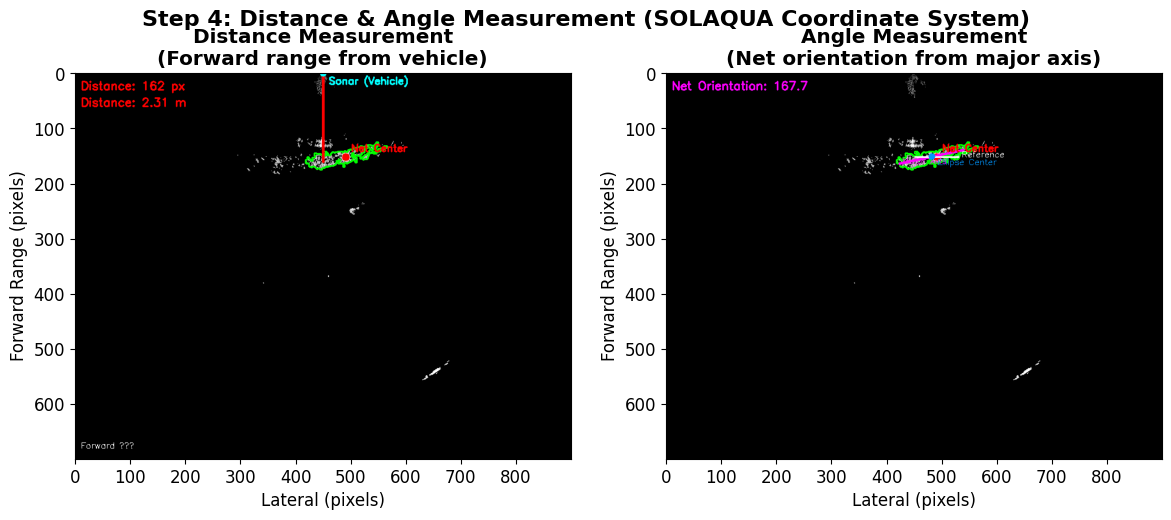

✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png
📍 Both panels now use consistent Smoothed Center for visualization


In [ ]:
# Step 4: Distance and Angle Measurement
print("Creating Figure 4: Distance and Angle Measurement")

# Create clean distance/angle visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Step 4: Distance & Angle Measurement (SOLAQUA Coordinate System)', fontsize=16, fontweight='bold')

H, W = frame_u8.shape

# UNIFIED CENTER POINT - use the same center for both visualizations
center_x, center_y = W//2, result.distance_pixels  # Default fallback

# Get center point (prioritize smoothed center if available)
if (isinstance(processor.current_aoi, dict) and 
    'smoothed_center' in processor.current_aoi and 
    processor.current_aoi['smoothed_center']):
    center_x, center_y = processor.current_aoi['smoothed_center']
    center_source = "Smoothed Center"
elif result.best_contour is not None and len(result.best_contour) >= 5:
    # Use ellipse center as backup
    try:
        (cx, cy), _, _ = cv2.fitEllipse(result.best_contour)
        center_x, center_y = cx, cy
        center_source = "Ellipse Center"
    except:
        center_source = "Default Center"
else:
    center_source = "Default Center"

print(f"Using {center_source}: ({center_x:.1f}, {center_y:.1f})")

# Distance measurement visualization
vis_distance = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if result.detection_success and result.distance_pixels is not None:
    # Draw the detection contour
    cv2.drawContours(vis_distance, [result.best_contour], -1, (0, 255, 0), 2)
    
    # SOLAQUA coordinate system: sonar is at TOP (y=0), distance measured forward (downward in pixels)
    sonar_x, sonar_y = W//2, 0  # Sonar at top center
    target_pixel_y = int(result.distance_pixels)  # Direct pixel distance from sonar
    
    # Draw UNIFIED net center
    cv2.circle(vis_distance, (int(center_x), int(center_y)), 8, (0, 0, 255), -1)
    cv2.circle(vis_distance, (int(center_x), int(center_y)), 8, (255, 255, 255), 1)  # White outline
    
    # Draw distance measurement - from sonar position to target y-coordinate
    cv2.line(vis_distance, (sonar_x, sonar_y), (sonar_x, target_pixel_y), 
            (0, 0, 255), 3)  # Vertical distance line from sonar
    
    # Add distance annotations
    cv2.putText(vis_distance, f'Distance: {result.distance_pixels:.0f} px', 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    if result.distance_meters is not None:
        cv2.putText(vis_distance, f'Distance: {result.distance_meters:.2f} m', 
                   (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Mark sonar position at TOP
    cv2.circle(vis_distance, (sonar_x, sonar_y), 6, (255, 255, 0), -1)
    cv2.putText(vis_distance, 'Sonar (Vehicle)', (sonar_x + 10, sonar_y + 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    # Add center label
    cv2.putText(vis_distance, 'Net Center', (int(center_x) + 10, int(center_y) - 10), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    # Add coordinate system info
    cv2.putText(vis_distance, 'Forward →', (10, H - 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

axes[0].imshow(cv2.cvtColor(vis_distance, cv2.COLOR_BGR2RGB))
axes[0].set_title('Distance Measurement\n(Forward range from vehicle)', fontweight='bold')
axes[0].set_xlabel('Lateral (pixels)')
axes[0].set_ylabel('Forward Range (pixels)')

# Angle measurement visualization (net orientation, not bearing)
vis_angle = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if result.detection_success and result.angle_degrees is not None:
    # Draw the detection contour
    cv2.drawContours(vis_angle, [result.best_contour], -1, (0, 255, 0), 2)
    
    # Draw SAME UNIFIED net center as left panel
    cv2.circle(vis_angle, (int(center_x), int(center_y)), 8, (0, 0, 255), -1)
    cv2.circle(vis_angle, (int(center_x), int(center_y)), 8, (255, 255, 255), 1)  # White outline
    
    # Get ellipse information for angle visualization
    if result.best_contour is not None and len(result.best_contour) >= 5:
        try:
            # Get ellipse parameters (same as used in angle calculation)
            (cx, cy), (minor_axis, major_axis), angle = cv2.fitEllipse(result.best_contour)
            
            # Draw ellipse major axis to show orientation (using ellipse center for axis calculation)
            angle_rad = np.radians(angle + 90.0)  # Major axis direction (same as in calculation)
            axis_length = 60  # Length for visualization
            dx = axis_length * np.cos(angle_rad)
            dy = axis_length * np.sin(angle_rad)
            
            # Draw major axis line through the ellipse center (not necessarily same as tracking center)
            p1 = (int(cx - dx), int(cy - dy))
            p2 = (int(cx + dx), int(cy + dy))
            cv2.line(vis_angle, p1, p2, (255, 0, 255), 3)
            
            # Draw reference horizontal line through unified center
            ref_length = 40
            cv2.line(vis_angle, (int(center_x - ref_length), int(center_y)), 
                    (int(center_x + ref_length), int(center_y)), (255, 255, 255), 2)
            
            # Angle annotation
            angle_text = f'Net Orientation: {result.angle_degrees:.1f}'
            cv2.putText(vis_angle, angle_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
            
            # Labels
            cv2.putText(vis_angle, 'Net Center', (int(center_x) + 10, int(center_y) - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(vis_angle, 'Major Axis', (p2[0] + 5, p2[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)
            cv2.putText(vis_angle, 'Reference', (int(center_x + ref_length) + 5, int(center_y)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
  
            
        except Exception as e:
            cv2.putText(vis_angle, f'Angle calc error: {e}', (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

axes[1].imshow(cv2.cvtColor(vis_angle, cv2.COLOR_BGR2RGB))
axes[1].set_title('Angle Measurement\n(Net orientation from major axis)', fontweight='bold')
axes[1].set_xlabel('Lateral (pixels)')
axes[1].set_ylabel('Forward Range (pixels)')

plt.tight_layout()
plt.savefig('/tmp/solaqua_step4_distance_angle.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure 4 saved: /tmp/solaqua_step4_distance_angle.png")
